In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

import matplotlib.pyplot as plt

%matplotlib inline
from google.cloud import bigquery
from google.oauth2 import service_account
key_path="/home/workflow/bigquey_key/eternal-calling-318816-1f09ae068787.json"

In [4]:
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [5]:
dataset_ref = client.dataset("google_analytics_sample", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

In [6]:
tables = list(client.list_tables(dataset))

In [7]:
table_ref = dataset_ref.table("ga_sessions_20170801")

In [8]:
table = client.get_table(table_ref)

In [97]:
query1 = """

SELECT * 
FROM 
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
_table_suffix = "20170801"

"""
safe_query_job= client.query(query1)
df = safe_query_job.to_dataframe()

In [98]:
df.columns

Index(['visitorId', 'visitNumber', 'visitId', 'visitStartTime', 'date',
       'totals', 'trafficSource', 'device', 'geoNetwork', 'customDimensions',
       'hits', 'fullVisitorId', 'userId', 'clientId', 'channelGrouping',
       'socialEngagementType'],
      dtype='object')

In [101]:
test = pd.DataFrame(df.groupby(['fullVisitorId']).apply(lambda x: len(x) > 1)).reset_index()

In [102]:
visitors = test[test[0] == True]['fullVisitorId'].values

In [103]:
df[df['fullVisitorId'].isin(visitors)].head()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
3,None,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
12,None,2,1501603594,1501603594,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': '/', 'campaign': '(not set)',...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 9, 'minut...",5485017567268822718,None,None,Referral,Not Socially Engaged
15,None,3,1501638744,1501638744,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 18, 'minu...",3239591421883808376,None,None,Organic Search,Not Socially Engaged
19,None,2,1501650737,1501650737,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Safari', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",9115044195942480006,None,None,Direct,Not Socially Engaged
24,None,27,1501656919,1501656919,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'South...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 23, 'minu...",3884810646891698298,None,None,Direct,Not Socially Engaged


### Total customers

In [104]:
total_unique_users = """

SELECT COUNT(DISTINCT fullVisitorId) as uniqueUsersQuant
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _table_suffix = "20170801"

"""
safe_query_job= client.query(total_unique_users)
query_df= safe_query_job.to_dataframe()

In [105]:
query_df

,unique_users_quant
0,2293


### Quantity of customers who visited platform more 1 time 

In [117]:
# count users who visited more than 1 time
query2 = """

SELECT COUNT(manyVisitsUsers) as totalQuantity
FROM
(

SELECT COUNT(*) as manyVisitsUsers
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _table_suffix = "20170801"
GROUP BY fullVisitorId
HAVING COUNT(*) > 1
) a
"""
safe_query_job= client.query(query2)
query_df1= safe_query_job.to_dataframe()

In [118]:
query_df1

,totalQuantity
0,216


## Customers distribution by country
____

In [194]:
# find most visited country from 
query3 ="""
    
    SELECT COUNT(DISTINCT fullVisitorId) as total_customers, geoNetwork.country as country
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE _table_suffix = "20170801"
    GROUP BY geoNetwork.country
    ORDER BY total_customers DESC
    
"""
safe_query_job= client.query(query3)
query_df3= safe_query_job.to_dataframe()

In [196]:
geo = px.data.gapminder()
geo = geo.drop_duplicates(subset=['country'])
query_df3 = pd.merge(query_df3, geo[['country','iso_alpha']], on =['country'], how='inner')

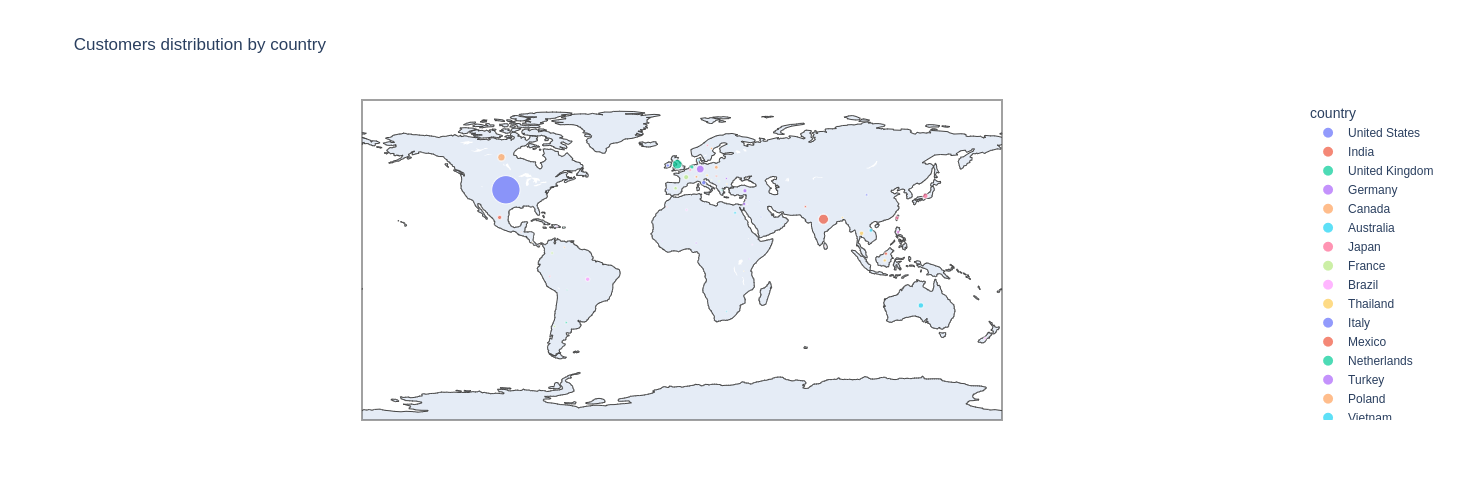

In [379]:
fig = px.scatter_geo(query_df3,locations="iso_alpha",
                      size="total_customers",
                      color="country", 
                      title="Customers distribution by country",
                      width = 1100,
                      height = 500,
                     )
fig.show()

### As we can see from this map, most of google merchandise are customers located in USA.
     Lets Examine Google USA merchandise market 

In [386]:
# revenue by state 
query4 ="""
    SELECT SUM(hits.transaction.transactionRevenue / 1000000) AS revenueTotal, geoNetwork.region AS state
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST (hits) AS hits
    WHERE _table_suffix = "20170801"
    AND geoNetwork.country = 'United States'
    GROUP BY geoNetwork.region
    ORDER BY revenueTotal DESC
    LIMIT 6

"""
safe_query_job= client.query(query4)
query_df4= safe_query_job.to_dataframe()

In [387]:
query_df4

,revenueTotal,state
0,3670.02,California
1,1723.23,New York
2,1448.89,not available in demo dataset
3,1442.46,Illinois
4,238.53,Georgia
5,137.07,Texas


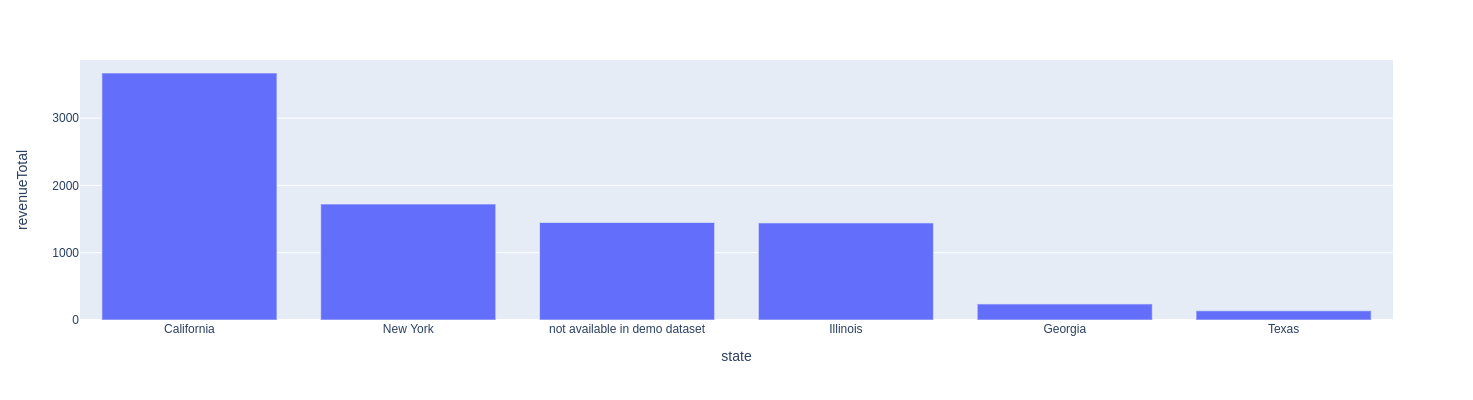

In [388]:
fig = px.bar(query_df4, x='state', y='revenueTotal',
             labels={'pop':'Revenue By State'}, height=400)
fig.show()

### Now lets find revenue/total customers in state ratio 

In [389]:
# revenue by state 
query5 ="""
    SELECT SUM(hits.transaction.transactionRevenue / 1000000) / COUNT(DISTINCT fullVisitorId) AS revenueByCustomer, geoNetwork.region AS state
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST (hits) AS hits
    WHERE _table_suffix = "20170801"
    AND geoNetwork.country = 'United States'
    GROUP BY geoNetwork.region
    ORDER BY revenueByCustomer DESC
    LIMIT 6
"""
safe_query_job = client.query(query5) 
query_df5 = safe_query_job.to_dataframe()

In [390]:
query_df5

,revenueByCustomer,state
0,62.715652,Illinois
1,23.853000,Georgia
2,20.514643,New York
3,10.576427,California
4,5.643333,Massachusetts
5,4.684286,Michigan


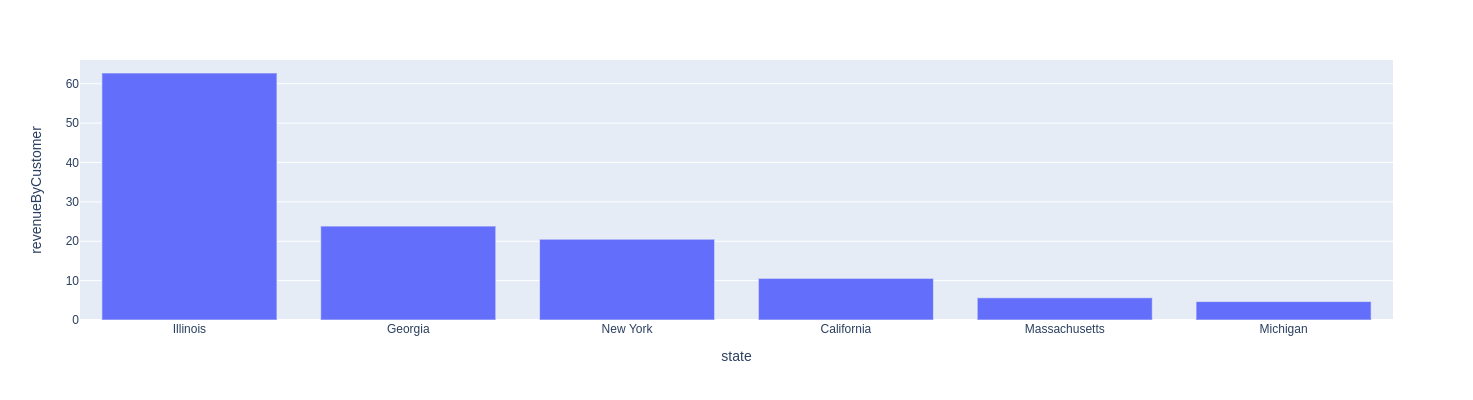

In [395]:
fig = px.bar(query_df5, x='state', y='revenueByCustomer',
             labels={'':'Revenue By Customer in USA'}, height=400)
fig.show()

### Comparing to total revenue by state(Where California customers bring biggest value), People in Illinois tend to buy more expensive items
    Lets find out what are most popular items in Illinois and California

In [397]:
query6 ="""
    
    SELECT COUNT(items.v2ProductCategory )AS categoryPurchases, v2ProductCategory, SUM(hits.transaction.transactionRevenue / 1000000) AS revenueTotalByCategory
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST (hits) AS hits,
    UNNEST(hits.product) AS items
    WHERE _table_suffix = "20170801"
    AND geoNetwork.country = 'United States' AND geoNetwork.region = 'Illinois'
    GROUP BY  items.v2ProductCategory
    ORDER BY revenueTotalByCategory DESC, 1
    LIMIT 10

"""
safe_query_job = client.query(query6) 
query_df6 = safe_query_job.to_dataframe()

In [398]:
query_df6

,categoryPurchases,v2ProductCategory,revenueTotalByCategory
0,87,Apparel,5443.79
1,22,Bags,1534.29
2,5,Headgear,985.73
3,5,Electronics,985.73
4,5,Drinkware,985.73
5,7,Notebooks & Journals,985.73
6,9,Office,985.73
7,9,${productitem.product.origCatName},274.28
8,2,Home/Electronics/Audio/,NaN
9,2,Waze,NaN


In [416]:
query7 ="""
    
    SELECT COUNT(items.v2ProductCategory )AS categoryPurchases, v2ProductCategory, SUM(hits.transaction.transactionRevenue / 1000000) AS revenueTotalByCategory
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST (hits) AS hits,
    UNNEST(hits.product) AS items
    WHERE _table_suffix = "20170801"
    AND geoNetwork.country = 'United States' AND geoNetwork.region = 'California'
    GROUP BY  items.v2ProductCategory
    ORDER BY revenueTotalByCategory DESC, 1
    LIMIT 10
"""
safe_query_job = client.query(query7) 
query_df7 = safe_query_job.to_dataframe()

In [417]:
query_df7

,categoryPurchases,v2ProductCategory,revenueTotalByCategory
0,36,Notebooks & Journals,5911.51
1,30,Drinkware,3196.43
2,21,Headgear,3163.67
3,58,Office,3043.45
4,294,Apparel,2557.64
5,7,Bags,178.39
6,13,Electronics,82.43
7,5,Fun,32.76
8,8,Home/Gift Cards/,NaN
9,34,Lifestyle,NaN


### Lets find out best-seller items in USA 

In [407]:
query8 ="""
    SELECT hits.eCommerceAction.action_type = "6
"""
safe_query_job = client.query(query8) 
query_df8 = safe_query_job.to_dataframe()

### Lets find out most popular(Viewed) product by state

In [431]:
query9 ="""
    SELECT*, RANK() OVER(PARTITION BY region ORDER BY ProductDetailViews DESC) Rank
    FROM
    (
   
    SELECT geoNetwork.region, SUM(CASE WHEN hits.eCommerceAction.action_type = "2" THEN 1 END) AS ProductDetailViews, items.v2ProductName AS product_name,
    FROM
    (
    SELECT*
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE _table_suffix = "20170801"  AND geoNetwork.country = 'United States'
    ),
    UNNEST (hits) AS hits,
    UNNEST(hits.product) AS items
    GROUP BY product_name, geoNetwork.region
     )
"""
safe_query_job = client.query(query9) 
query_df9 = safe_query_job.to_dataframe()

In [441]:
query_df9

,region,ProductDetailViews,product_name,Rank
0,Massachusetts,6.0,Google Men's Zip Hoodie,1
1,Massachusetts,4.0,Google Women's 3/4 Sleeve Baseball Raglan Heat...,2
2,Massachusetts,3.0,Recycled Mouse Pad,3
3,Massachusetts,3.0,8 pc Android Sticker Sheet,3
4,Massachusetts,2.0,Google Doodle Decal,5
...,...,...,...,...
1776,(not set),NaN,YouTube Men's Short Sleeve Hero Tee Black,2
1777,(not set),NaN,YouTube Men's Long & Lean Tee Charcoal,2
1778,(not set),NaN,YouTube Women's Short Sleeve Hero Tee Charcoal,2
1779,(not set),NaN,YouTube Women's Short Sleeve Tri-blend Badge T...,2


### Have no idea how to vizualize it :) but the usage of window functions looks cool LOL

## Conclusion :